In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

import cv2

In [ ]:
class GetData:
    def __init__(self, path, resloution):
        self.path = path
        self.resloution = resloution
        
        self.training_csv = pd.read_csv(path + '/car_boundingBox_class_and_image_number.csv')
        self.testing_csv = pd.read_csv(path + '/car_dataset_test_boundingBox_image_number.csv')
        self.training_images_path = path + '/cars_training_image/cars_train/'
        self.testing_images_path = path + '/cars_testing_image/car_test_with_adv_attack/'
        self.class_names = pd.read_csv(path + '/car_class_and_model.csv')

    def get_training_data(self):
        images = []
        labels = []

        training_images_path = self.training_images_path
        for _ , row in self.training_csv.iterrows():        
            image = cv2.imread(training_images_path + row['image'])
    
            # crop the image
            x1 = row['x1'].values[0]
            y1 = row['y1'].values[0]
            x2 = row['x2'].values[0]
            y2 = row['y2'].values[0]
            image = image[y1:y2, x1:x2]

            # normalize and resize
            image = self.preprocess_image(image) 

            images.append(image)
            labels.append(row['Class'])

        return np.array(images), np.array(labels)
    
    def get_testing_data(self):
        images = []
        labels = []

        testing_images_path = self.testing_images_path
        for _ , row in self.testing_csv.iterrows():
            image = cv2.imread(testing_images_path + row['image'])
            image = self.preprocess_image(image)           
            images.append(image)

        return np.array(images), np.array(labels)
    
    def get_data(self, type = 'train'):
        if type == 'train':
            path = self.training_images_path
            csv = self.training_csv
        else:
            path = self.testing_images_path
            csv = self.testing_csv

        images = []
        labels = []
        for _ , row in csv.iterrows():
            image = cv2.imread(path + row['image'])
            
            # crop the image
            #x1 = row['x1'].values[0]
            #y1 = row['y1'].values[0]
            #x2 = row['x2'].values[0]
            #y2 = row['y2'].values[0]
            #image = image[y1:y2, x1:x2]
            
            # normalize and resize
            image = self.preprocess_image(image)           
            images.append(image)

            if type == 'train':
                labels.append(row['Class'])

        if type == 'train':
            return np.array(images), np.array(labels)
        else:
            return np.array(images)
    
    def preprocess_image(self, img):
        # normalize
        img = img / 255.0

        # lower resolution
        img = cv2.resize(img, (self.resloution, self.resloution))
        return img
    
    def get_class_names(self, class_number):
        return self.class_names['Class_name'][class_number]
    
resolution = 64
num_classes = 198

#data_getter = GetData('car-classification-with-adversarial-defense', resolution)
#test_images = data_getter.get_data('test')
#train_images, train_labels = data_getter.get_data('train')

In [ ]:
import threading
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import numpy as np

def get_data(index):
    csv = pd.read_csv('car-classification-with-adversarial-defense/car_boundingBox_class_and_image_number.csv')
    image_number = csv['image'][index]
    class_number = csv['Class'][index]
    
    x1 = csv['x1'][index]
    y1 = csv['y1'][index]
    x2 = csv['x2'][index]
    y2 = csv['y2'][index]

    return image_number, class_number, x1, y1, x2, y2

def get_image(index):
    image_number, class_number, x1, y1, x2, y2 = get_data(index)
    image = cv2.imread('car-classification-with-adversarial-defense/cars_training_image/cars_train/' + image_number)
    image_array = np.array(image)
    image_array = image_array[y1:y2, x1:x2]
    return image_array, class_number

def rotate_image(image, angle):
    image_center = tuple(np.array(image.shape[1::-1]) / 2)
    rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
    result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
    return result

def add_noise(image, sigma=0.03, mean=0):
    row, col, ch = image.shape
    gauss = np.random.normal(mean, sigma, (row, col, ch))
    gauss = gauss.reshape(row, col, ch)
    noisy = image + gauss
    return noisy

def flip(image):
    return cv2.flip(image, 1)

def preprocess_image(image, noise, angle, flipping, class_number, train_images, train_labels, lock, resolution=64):
    # lower resolution
    image = cv2.resize(image, (resolution, resolution))

    # grayscale
    #image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # normalize
    image = image / 255.0

    image = rotate_image(image, angle)
    
    image = add_noise(image, noise)

    if flipping: image = flip(image)    
    
    # Add lock to safely append to lists
    with lock:
        train_images.append(image)
        train_labels.append(class_number)

def thread_task(index, train_images, train_labels, lock):
    image_array, class_number = get_image(index)
    for noise in [0.03, 0.0]:
        for angle in [-5, 0, 5]:
            for flipping in [False, True]:  # Now also includes flipping
                preprocess_image(image_array, noise, angle, flipping, class_number, train_images, train_labels, lock)

train_images = []
train_labels = []
threads = []
lock = threading.Lock()  # Lock for safe appending

num_images = 8144

for i in range(num_images):  
    thread = threading.Thread(target=thread_task, args=(i, train_images, train_labels, lock))
    threads.append(thread)
    thread.start()
    if i % 100 == 0:
        print(f'{i} images processed')

# Wait for all threads to finish
for t, thread in enumerate(threads):
    thread.join()
    if t % 100 == 0:
        print(f'{t} threads joined')

print("Image processing completed with threading.")

0 images processed
100 images processed
200 images processed
300 images processed
400 images processed
500 images processed
600 images processed
700 images processed
800 images processed
900 images processed
1000 images processed
1100 images processed
1200 images processed
1300 images processed
1400 images processed
1500 images processed
1600 images processed
1700 images processed
1800 images processed
1900 images processed
2000 images processed
2100 images processed
2200 images processed
2300 images processed
2400 images processed
2500 images processed
2600 images processed
2700 images processed
2800 images processed
2900 images processed
3000 images processed
3100 images processed
3200 images processed
3300 images processed
3400 images processed
3500 images processed
3600 images processed
3700 images processed
3800 images processed
3900 images processed
4000 images processed
4100 images processed
4200 images processed
4300 images processed
4400 images processed
4500 images processed


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(64, 64, 3)


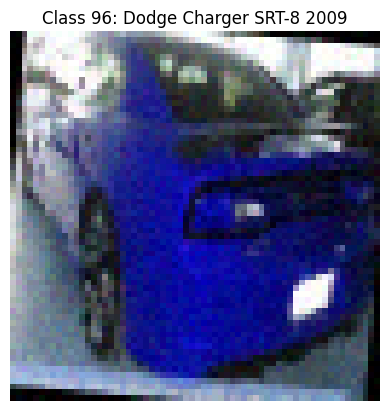

In [4]:
data_getter = GetData('car-classification-with-adversarial-defense', resolution)
plt.axis('off')
plt.title(f'Class {train_labels[0]}: {data_getter.get_class_names(train_labels[0])}')
plt.imshow(train_images[0])
print(train_images[0].shape)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(64, 64, 3)


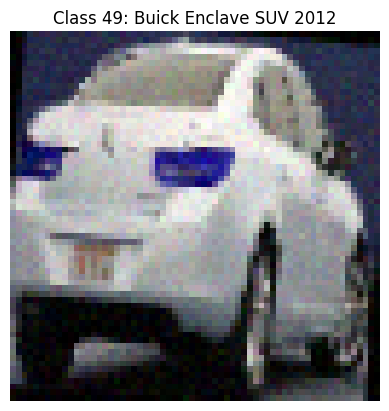

In [10]:
# shape is (293184, 64, 64, 3)
# reshape to (293184, 64, 64)
plt.axis('off')
plt.title(f'Class {train_labels[3]}: {data_getter.get_class_names(train_labels[3])}')
plt.imshow(train_images[3])
print(train_images[3].shape)

In [11]:
model = models.Sequential()

# First convolutional block
model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(resolution, resolution, 3)))  # Change to single channel
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.3))

# Second convolutional block
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.3))

# Third convolutional block
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.3))

# Fourth convolutional block
model.add(layers.Conv2D(512, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.4))

# Flatten and fully connected layers
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))

# Output layer with Softmax activation for classification
model.add(layers.Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [12]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 62, 62, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 62, 62, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 31, 31, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 31, 31, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 29, 29, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 29, 29, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 4, 4, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 4, 4, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 198)            │        50,886 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,131,270 (8.13 MB)

 Trainable params: 2,128,838 (8.12 MB)

 Non-trainable params: 2,432 (9.50 KB)

In [13]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


# split the training data to training and validation data
from sklearn.model_selection import train_test_split
train_images = np.array(train_images)
train_labels = np.array(train_labels)
X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)

print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(78182, 64, 64, 3)
(19546, 64, 64, 3)
(78182,)
(19546,)


In [20]:
history = model.fit(X_train, y_train, epochs=1, 
                    validation_data=(X_val, y_val))

2444/2444 ━━━━━━━━━━━━━━━━━━━━ 379s 155ms/step - accuracy: 0.2141 - loss: 3.3777 - val_accuracy: 0.4933 - val_loss: 1.9950


In [21]:
test_loss, test_acc = model.evaluate(X_val,  y_val, verbose=2)
print(test_acc)

611/611 - 19s - 30ms/step - accuracy: 0.4933 - loss: 1.9950
0.49329787492752075


(64, 64, 3)


ValueError: x and y can be no greater than 2D, but have shapes (64,) and (64, 64, 3)

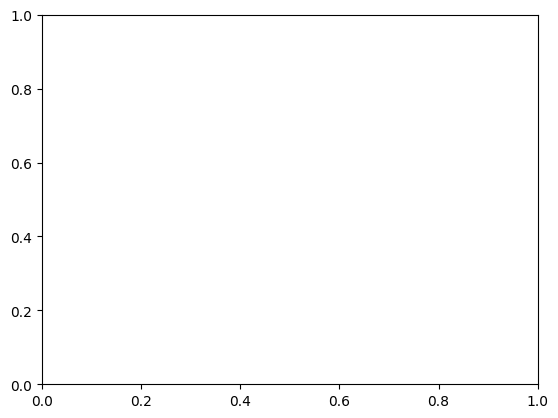

In [34]:
print(X_train[20].shape)
test_image_index = 20
plt.plot(X_train[test_image_index])
plt.show()

In [22]:
test_images = data_getter.get_data('test')

In [23]:
print(test_images.shape)
predictions = model.predict(test_images)

# use argmax to get the class number
predictions = np.argmax(predictions, axis=1)
#[data_getter.get_class_names(i) if i < 196: else: 'IDK' for i in predictions]

class_names = []
for i in predictions:
    if i < 196:
        class_names.append(data_getter.get_class_names(i))
    else:
        class_names.append('IDK')

# save the results to a csv file
results = pd.DataFrame()
# ID, Class name
results['ID'] = range(1, 1 + len(class_names))
results['Car_Model'] = class_names
results.to_csv('results.csv', index=False)


(8041, 64, 64, 3)
252/252 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step


In [24]:
# count the number of IDKs in class_names
count = 0
for i in class_names:
    if i == 'IDK':
        count += 1
print(count)

24
